In [43]:
import numpy as np
import pandas as pd
import random
import re
import multiprocessing
import gensim
from tqdm import tqdm
import sys
from nltk import word_tokenize

from owl2vec_star.lib.Evaluator import Evaluator
from owl2vec_star.lib.RDF2Vec_Embed import get_rdf2vec_walks

In [6]:
class AttributeDict(dict):
    def __getattr__(self, attr):
        return self[attr]

    def __setattr__(self, attr, value):
        self[attr] = value

# Usage
FLAGS = AttributeDict()
FLAGS['onto_file'] = "files/helis_v1.00.train.projection.ttl"
FLAGS['train_file'] = "files/train.csv"
FLAGS['valid_file'] = "files/valid.csv"
FLAGS['test_file'] = "files/test.csv"
FLAGS['class_file'] = "files/classes.txt"
FLAGS['individual_file'] = "files/individuals.txt"
FLAGS['inferred_class_file'] = "files/inferred_classes.txt"
FLAGS["embedsize"] = 100

FLAGS["URI_Doc"] ="yes"
FLAGS["Lit_Doc"] ="yes"
FLAGS["Mix_Doc"] ="yes"
FLAGS["Mix_Type"] ="random"
FLAGS["Embed_Out_URI"] ="yes"
FLAGS["Embed_Out_Words"] ="yes"

FLAGS["input_type"] ="concatenate"
FLAGS["walk_depth"] = 4
FLAGS["walker"] ="wl"
FLAGS["axiom_file"] ='files/axioms.txt'
FLAGS["annotation_file"] ='files/annotations.txt'

individuals = [line.strip() for line in open(FLAGS.individual_file).readlines()]
classes = [line.strip() for line in open(FLAGS.class_file).readlines()]
candidate_num = len(classes)

In [3]:

def embed(model, instances):
    def word_embeding(inst):
        v = np.zeros(model.vector_size)
        if inst in uri_label:
            words = uri_label.get(inst)
            n = 0
            for word in words:
                if word in model.wv.index_to_key:
                    v += model.wv.get_vector(word)
                    n += 1
            return v / n if n > 0 else v
        else:
            return v

    feature_vectors = []
    for instance in instances:
        if FLAGS.Embed_Out_Words.lower() == 'yes' and FLAGS.Embed_Out_URI.lower() == 'yes':
            v_uri = model.wv.get_vector(instance) if instance in model.wv.index_to_key else np.zeros(model.vector_size)
            v_word = word_embeding(inst=instance)
            feature_vectors.append(np.concatenate((v_uri, v_word)))

        elif FLAGS.Embed_Out_Words.lower() == 'no' and FLAGS.Embed_Out_URI.lower() == 'yes':
            v_uri = model.wv.get_vector(instance) if instance in model.wv.index_to_key else np.zeros(model.vector_size)
            feature_vectors.append(v_uri)

        elif FLAGS.Embed_Out_Words.lower() == 'yes' and FLAGS.Embed_Out_URI.lower() == 'no':
            v_word = word_embeding(inst=instance)
            feature_vectors.append(v_word)

        else:
            print("Unknown embed out type")
            sys.exit(0)

    return feature_vectors


def pre_process_words(words):
    text = ' '.join([re.sub(r'https?:\/\/.*[\r\n]*', '', word, flags=re.MULTILINE) for word in words])
    tokens = word_tokenize(text)
    processed_tokens = [token.lower() for token in tokens if token.isalpha()]
    return processed_tokens


def URI_parse(uri):
    """Parse a URI: remove the prefix, parse the name part (Camel cases are plit)"""
    uri = re.sub("http[a-zA-Z0-9:/._-]+#", "", uri)
    uri = uri.replace('_', ' ').replace('-', ' ').replace('.', ' ').replace('/', ' '). \
        replace('"', ' ').replace("'", ' ')
    words = []
    for item in uri.split():
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', item)
        for m in matches:
            word = m.group(0)
            if word.isalpha():
                words.append(word.lower())
    return words

In [4]:

print("\n		1.Extract corpus and learning embedding ... \n")

annotations = list()
uri_label = dict()
for line in open(FLAGS.annotation_file).readlines():
    tmp = line.strip().split()
    if tmp[1] not in ['http://www.w3.org/2000/01/rdf-schema#label', 'http://www.fbk.eu/ontologies/virtualcoach#id'] \
            and tmp[0] in classes + individuals:
        annotations.append(tmp)
    if tmp[1] == 'http://www.w3.org/2000/01/rdf-schema#label':
        uri_label[tmp[0]] = pre_process_words(tmp[2:])
for ent in individuals + classes:
    if ent not in uri_label:
        uri_label[ent] = URI_parse(ent)


		1.Extract corpus and learning embedding ... 



In [7]:

walk_sentences, axiom_sentences = list(), list()
if FLAGS.URI_Doc.lower() == 'yes':
    walks_ = get_rdf2vec_walks(onto_file=FLAGS.onto_file, walker_type=FLAGS.walker,
                               walk_depth=FLAGS.walk_depth, classes=classes + individuals)
    print('Extracted {} walks for {} classes/individuals!'.format(len(walks_), len(classes) + len(individuals)))
    walk_sentences += [list(map(str, x)) for x in walks_]
    for line in open(FLAGS.axiom_file).readlines():
        axiom_sentence = [item for item in line.strip().split()]
        axiom_sentences.append(axiom_sentence)
    print('Extracted %d axiom sentences' % len(axiom_sentences))
URI_Doc = walk_sentences + axiom_sentences

Extracted 5828824 walks for 20595 classes/individuals!
Extracted 137512 axiom sentences


In [8]:

Lit_Doc = list()
if FLAGS.Lit_Doc.lower() == 'yes':
    for annotation in annotations:
        processed_words = pre_process_words(annotation[2:])
        if len(processed_words) > 0:
            Lit_Doc.append(uri_label[annotation[0]] + processed_words)
    print('Extracted %d literal annotations' % len(Lit_Doc))

    for sentence in walk_sentences:
        lit_sentence = list()
        for item in sentence:
            if item in uri_label:
                lit_sentence += uri_label[item]
            elif item.startswith('http://www.w3.org'):
                lit_sentence += [item.split('#')[1].lower()]
            else:
                lit_sentence += [item]
        Lit_Doc.append(lit_sentence)

    for sentence in axiom_sentences:
        lit_sentence = list()
        for item in sentence:
            lit_sentence += uri_label[item] if item in uri_label else [item.lower()]
        Lit_Doc.append(lit_sentence)

Extracted 222 literal annotations


In [9]:

Mix_Doc = list()
if FLAGS.Mix_Doc.lower() == 'yes':
    for sentence in walk_sentences:
        if FLAGS.Mix_Type.lower() == 'all':
            for index in range(len(sentence)):
                mix_sentence = list()
                for i, item in enumerate(sentence):
                    if i == index:
                        mix_sentence += [item]
                    else:
                        if item in uri_label:
                            mix_sentence += uri_label[item]
                        elif item.startswith('http://www.w3.org'):
                            mix_sentence += [item.split('#')[1].lower()]
                        else:
                            mix_sentence += [item]
                Mix_Doc.append(mix_sentence)
        elif FLAGS.Mix_Type.lower() == 'random':
            random_index = random.randint(0, len(sentence) - 1)
            mix_sentence = list()
            for i, item in enumerate(sentence):
                if i == random_index:
                    mix_sentence += [item]
                else:
                    if item in uri_label:
                        mix_sentence += uri_label[item]
                    elif item.startswith('http://www.w3.org'):
                        mix_sentence += [item.split('#')[1].lower()]
                    else:
                        mix_sentence += [item]
            Mix_Doc.append(mix_sentence)

    for sentence in axiom_sentences:
        if FLAGS.Mix_Type.lower() == 'all':
            for index in range(len(sentence)):
                random_index = random.randint(0, len(sentence) - 1)
                mix_sentence = list()
                for i, item in enumerate(sentence):
                    if i == random_index:
                        mix_sentence += [item]
                    else:
                        mix_sentence += uri_label[item] if item in uri_label else [item.lower()]
                Mix_Doc.append(mix_sentence)
        elif FLAGS.Mix_Type.lower() == 'random':
            random_index = random.randint(0, len(sentence) - 1)
            mix_sentence = list()
            for i, item in enumerate(sentence):
                if i == random_index:
                    mix_sentence += [item]
                else:
                    mix_sentence += uri_label[item] if item in uri_label else [item.lower()]
            Mix_Doc.append(mix_sentence)


In [10]:
print('URI_Doc: %d, Lit_Doc: %d, Mix_Doc: %d' % (len(URI_Doc), len(Lit_Doc), len(Mix_Doc)))
all_doc = URI_Doc + Lit_Doc + Mix_Doc
random.shuffle(all_doc)

URI_Doc: 5966336, Lit_Doc: 5966558, Mix_Doc: 5966336


In [11]:
pd.DataFrame(URI_Doc)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Anim...,http://www.w3.org/2002/07/owl#sameAs,http://www.fbk.eu/ontologies/virtualcoach#Anim...,None,None,None,None,None,None,None,None,None,None,None
1,http://www.fbk.eu/ontologies/virtualcoach#RECI...,http://www.w3.org/2002/07/owl#sameAs,b'\x8a*\xd6\xe5\x142\xc1\xcb\x19aE\xd5 \x19\xc...,http://www.fbk.eu/ontologies/virtualcoach#amou...,b'k\x8f\x8a\xb2C&\xbf\x94\x05\xb3\x1d\x95\x90\...,None,None,None,None,None,None,None,None,None,None,None
2,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Sucr...,http://www.fbk.eu/ontologies/virtualcoach#amou...,0.0,None,None,None,None,None,None,None,None,None,None,None
3,http://www.fbk.eu/ontologies/virtualcoach#Glut...,http://no.sirius.ontology/annotations#direct_type,b'\xf1&\x9c\xae \xedGv\xf0\x8e\xc0\xa8\xc9\x01...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,"b'\xda\x8e\x87\x97\xb7^:r,t\x08v\xf0\xe7Q\xdf'",None,None,None,None,None,None,None,None,None,None,None
4,http://www.fbk.eu/ontologies/virtualcoach#Phen...,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,b'\xf4\xd9~\xda\rA\x91\xfa\xeccT\xe2\x14\xd4\x...,http://www.w3.org/2000/01/rdf-schema#label,"b""\xa1\xd6\x0c_\xc8'%\xa8G\xe8\xd4\xed\x7f\xf9...",None,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5966331,http://www.fbk.eu/ontologies/virtualcoach#Seri...,http://www.fbk.eu/ontologies/virtualcoach#unit,"""mg""^^http://www.w3.org/2001/XMLSchema#string",None,None,None,None,None,None,None,None,None,None,None,None,None
5966332,http://www.fbk.eu/ontologies/virtualcoach#Seri...,http://www.fbk.eu/ontologies/virtualcoach#amou...,"""198.0""^^http://www.w3.org/2001/XMLSchema#double",None,None,None,None,None,None,None,None,None,None,None,None,None
5966333,http://www.fbk.eu/ontologies/virtualcoach#Prot...,Type,http://www.fbk.eu/ontologies/virtualcoach#Protein,None,None,None,None,None,None,None,None,None,None,None,None,None
5966334,http://www.fbk.eu/ontologies/virtualcoach#Prot...,http://www.fbk.eu/ontologies/virtualcoach#unit,"""g""^^http://www.w3.org/2001/XMLSchema#string",None,None,None,None,None,None,None,None,None,None,None,None,None


In [12]:
model_ = gensim.models.Word2Vec(all_doc, vector_size=FLAGS.embedsize, window=5, workers=multiprocessing.cpu_count(),
                                    sg=1, epochs=10, negative=25, min_count=1, seed=42)

In [13]:

classes_e = embed(model=model_, instances=classes)
new_embedsize = classes_e[0].shape[0]
individuals_e = embed(model=model_, instances=individuals)

In [14]:
pd.DataFrame(classes_e).to_csv(r'D:\.VScode\projects\Owls2Vec_star\Workspace\TTL\Helis_classes_e.csv', index=False, header=False)
pd.DataFrame(individuals_e).to_csv(r'D:\.VScode\projects\Owls2Vec_star\Workspace\TTL\Helis_individuals_e.csv', index=False, header=False)

In [15]:
classes_e = pd.read_csv(r'D:\.VScode\projects\Owls2Vec_star\Workspace\TTL\Helis_classes_e.csv', header=None).to_numpy()
new_embedsize = classes_e[0].shape[0]
individuals_e = pd.read_csv(r'D:\.VScode\projects\Owls2Vec_star\Workspace\TTL\Helis_individuals_e.csv', header=None).to_numpy()

In [16]:

print("\n		2.Train and test ... \n")
train_samples = [line.strip().split(',') for line in open(FLAGS.train_file).readlines()]
valid_samples = [line.strip().split(',') for line in open(FLAGS.valid_file).readlines()]
test_samples = [line.strip().split(',') for line in open(FLAGS.test_file).readlines()]
random.shuffle(train_samples)


		2.Train and test ... 



In [17]:

train_x_list, train_y_list = list(), list()
for s in train_samples:
    ind, cls, label = s[0], s[1], s[2]
    ind_v = individuals_e[individuals.index(ind)]
    cls_v = classes_e[classes.index(cls)]
    if not (np.all(ind_v == 0) or np.all(cls_v == 0)):
        if FLAGS.input_type == 'concatenate':
            train_x_list.append(np.concatenate((ind_v, cls_v)))
        else:
            train_x_list.append(ind_v - cls_v)
        train_y_list.append(int(label))
train_X, train_y = np.array(train_x_list), np.array(train_y_list)
print('train_X: %s, train_y: %s' % (str(train_X.shape), str(train_y.shape)))

train_X: (28444, 400), train_y: (28444,)


In [18]:
ind_infer_classes = dict()
with open(FLAGS.inferred_class_file) as f:
    for line in f.readlines():
        tmp = line.strip().split(',')
        ind = tmp[0]
        ind_infer_classes[ind] = tmp[1:]


In [19]:
class InclusionEvaluator(Evaluator):
    def __init__(self, valid_samples, test_samples, train_X, train_y):
        super(InclusionEvaluator, self).__init__(valid_samples, test_samples, train_X, train_y)

    def evaluate(self, model, eva_samples):
        print('Evaluating...')
        X_array = np.empty((len(eva_samples), candidate_num, train_X.shape[1]), dtype=np.float32)
        for index, (individual, gt) in enumerate(eva_samples):
            individual_index = individuals.index(individual)
            individual_v = individuals_e[individual_index]
            X_array[index] = np.concatenate((np.array([individual_v] * candidate_num), classes_e), axis=1)
            
        predicted_proba_array = X_array.reshape(-1, train_X.shape[1])
        predicted_proba_array = model.predict_proba(predicted_proba_array)[:, 1].reshape((len(eva_samples), candidate_num))
        
        MRR_sum, hits1_sum, hits5_sum, hits10_sum = 0, 0, 0, 0
        for P, (individual, gt) in zip(predicted_proba_array, eva_samples):
            sorted_indexes = np.argsort(P)[::-1]
            sorted_classes = list()
            for j in sorted_indexes:
                if classes[j] not in ind_infer_classes[individual]:
                    sorted_classes.append(classes[j])
            rank = sorted_classes.index(gt) + 1
            MRR_sum += 1.0 / rank
            hits1_sum += 1 if gt in sorted_classes[:1] else 0
            hits5_sum += 1 if gt in sorted_classes[:5] else 0
            hits10_sum += 1 if gt in sorted_classes[:10] else 0
        eva_n = len(eva_samples)
        e_MRR, hits1, hits5, hits10 = MRR_sum / eva_n, hits1_sum / eva_n, hits5_sum / eva_n, hits10_sum / eva_n
        return e_MRR, hits1, hits5, hits10

In [20]:
print("\n		2.Train and test ... \n")
evaluator = InclusionEvaluator(valid_samples, test_samples, train_X, train_y)
evaluator.run_random_forest()


		2.Train and test ... 



Evaluating...
Testing, MRR: 0.947, Hits@1: 0.929, Hits@5: 0.972, Hits@10: 0.984




# Concept2Vec

In [21]:
TRAIN_PATH = r"D:\.VScode\projects\Owls2Vec_star\Workspace\TTL\KGE_data\Helis\train_dataset.tsv"

In [38]:
class ConceptClass:
    def __init__(self, concept, concept_embedded_vector, entities, entities_embedded_vectors):
        self.concept = concept
        self.concept_embedded_vector = concept_embedded_vector
        self.entities = entities 
        self.entities_embedded_vectors = entities_embedded_vectors

        self.average_entities_vectors = self.average_entities_vectors()
        
    def __repr__(self):
        return f'concept: {self.concept}'
    
    def similarity(self, vec1, vec2):
        return np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    
    def coherence_score(self, res_concepts, target_concept):
        return sum(res_concepts == target_concept) / res_concepts.shape[0]
    
    def average_entities_vectors(self):
        return np.mean(self.entities_embedded_vectors, axis = 0)
    
class OntologyEvaluation:
    def __init__(self, triples, entity_to_id, embedded_vectors, type_relations = 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'):
        self.type_relations = triples[(triples.iloc[:,1] == type_relations)]
        self.entity_to_id = entity_to_id
        self.embedded_vector = embedded_vectors
        
        self.concepts = self.filter_concepts_from_triples()
        self.concat_df = self.create_concat_embedded_vectors()

    def create_concat_embedded_vectors(self):
        concat_df = []
        for concept in self.concepts:
            _df = pd.DataFrame({'vector': [i for i in concept.entities_embedded_vectors]})
            _df['label'] = concept.concept
            concat_df.append(_df)
        concat_df = pd.concat(concat_df, axis=0).reset_index(drop=True)
        return concat_df
        
    def filter_concepts_from_triples(self, filter_num = 100):
        concepts_count = pd.DataFrame(self.type_relations.iloc[:, 2]).value_counts(sort = True)
        evalution_concepts = concepts_count[concepts_count > filter_num]
        print(evalution_concepts)
        
        filter_concepts = evalution_concepts.index.to_list()
        filter_concepts_class = []
        for concept in filter_concepts:
            concept = concept[0]
            concept_embedded_vector = self.get_embedded_vectors_from_label(concept)
            if concept_embedded_vector is None:
                continue  
            entities = self.get_entities_from_concept(concept)
            entities_embedded_vector = self.get_embedded_vectors_from_labels(entities)
            
            filter_concepts_class.append(ConceptClass(concept, concept_embedded_vector, entities, entities_embedded_vector))
            
        return filter_concepts_class
    
    def get_entities_from_concept(self, concept):
        entities = self.type_relations[self.type_relations.iloc[:,2] == concept].iloc[:,0]
        return entities
    
    def get_embedded_vectors_from_label(self, label):
        #Get index from label
        if label in self.entity_to_id:
            index = self.entity_to_id[label]
        else:
            print(f'{label} not in the ontology')
            return None
        
        #Get embedded vector from index
        concept_embedded_vector = self.embedded_vector[index]
        return concept_embedded_vector
    
    def get_embedded_vectors_from_labels(self, labels):
        concept_embedded_vectors = []
        for label in labels:
            concept_embedded_vectors.append(self.get_embedded_vectors_from_label(label))
        return np.array(concept_embedded_vectors)
        

In [23]:
triples = pd.read_csv(TRAIN_PATH, header=None, names=['head', 'relation', 'tail'])
triples.head()

,head,relation,tail
0,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Meth...
1,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Magn...
2,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Lysi...
3,http://www.fbk.eu/ontologies/virtualcoach#FOOD...,http://www.fbk.eu/ontologies/virtualcoach#hasN...,http://www.fbk.eu/ontologies/virtualcoach#Chlo...
4,http://www.fbk.eu/ontologies/virtualcoach#Sele...,http://no.sirius.ontology/annotations#direct_type,http://www.fbk.eu/ontologies/virtualcoach#Sele...


In [26]:
individuals_classes_dict = {cls: i for i, cls in enumerate(individuals + classes)}
individuals_classes_e = np.concatenate([individuals_e,classes_e], axis=0)

In [39]:
evalution_concepts = OntologyEvaluation(triples, individuals_classes_dict, individuals_classes_e)

tail                                                          
http://www.fbk.eu/ontologies/virtualcoach#RecipeFood              1002
http://www.fbk.eu/ontologies/virtualcoach#Recipe                   804
http://www.fbk.eu/ontologies/virtualcoach#MonounsaturatedLipid     322
http://www.fbk.eu/ontologies/virtualcoach#SaturatedLipid           321
http://www.fbk.eu/ontologies/virtualcoach#OleicAcid                303
http://www.w3.org/2002/07/owl#Class                                277
http://www.fbk.eu/ontologies/virtualcoach#Lysine                   268
http://www.fbk.eu/ontologies/virtualcoach#AsparticAcid             259
http://www.fbk.eu/ontologies/virtualcoach#Potassium                257
http://www.fbk.eu/ontologies/virtualcoach#GlutamicAcid             256
http://www.fbk.eu/ontologies/virtualcoach#Leucine                  253
http://www.fbk.eu/ontologies/virtualcoach#Valine                   249
http://www.fbk.eu/ontologies/virtualcoach#Isoleucine               248
http://www.fbk

In [40]:
for task in evalution_concepts.concepts:
    print(f'{task.concept: <35}: {task.similarity(task.concept_embedded_vector, task.average_entities_vectors):.3f}')

http://www.fbk.eu/ontologies/virtualcoach#RecipeFood: 0.607
http://www.fbk.eu/ontologies/virtualcoach#Recipe: 0.771
http://www.fbk.eu/ontologies/virtualcoach#MonounsaturatedLipid: 0.680
http://www.fbk.eu/ontologies/virtualcoach#SaturatedLipid: 0.730
http://www.fbk.eu/ontologies/virtualcoach#OleicAcid: 0.804
http://www.fbk.eu/ontologies/virtualcoach#Lysine: 0.837
http://www.fbk.eu/ontologies/virtualcoach#AsparticAcid: 0.811
http://www.fbk.eu/ontologies/virtualcoach#Potassium: 0.840
http://www.fbk.eu/ontologies/virtualcoach#GlutamicAcid: 0.809
http://www.fbk.eu/ontologies/virtualcoach#Leucine: 0.717
http://www.fbk.eu/ontologies/virtualcoach#Valine: 0.846
http://www.fbk.eu/ontologies/virtualcoach#Isoleucine: 0.838
http://www.fbk.eu/ontologies/virtualcoach#Carbs: 0.795
http://www.fbk.eu/ontologies/virtualcoach#Phenylalanine: 0.840
http://www.fbk.eu/ontologies/virtualcoach#Glycine: 0.863
http://www.fbk.eu/ontologies/virtualcoach#Arginine: 0.844
http://www.fbk.eu/ontologies/virtualcoach#Seri

In [41]:
top_k = 20
concat_df = evalution_concepts.concat_df
for task in evalution_concepts.concepts:

    res_sims = concat_df.iloc[:, 0].map(lambda x: task.similarity(x, task.concept_embedded_vector)).sort_values(ascending=False).head(top_k)
    res_concepts = concat_df['label'].loc[res_sims.index]
    res_score = task.coherence_score(res_concepts, task.concept)
    print(f'{task.concept: <35}: {res_score:.3f} | {task.entities.shape[0] / concat_df.shape[0]:.3f}')

http://www.fbk.eu/ontologies/virtualcoach#RecipeFood: 0.000 | 0.092
http://www.fbk.eu/ontologies/virtualcoach#Recipe: 1.000 | 0.074
http://www.fbk.eu/ontologies/virtualcoach#MonounsaturatedLipid: 1.000 | 0.029
http://www.fbk.eu/ontologies/virtualcoach#SaturatedLipid: 1.000 | 0.029
http://www.fbk.eu/ontologies/virtualcoach#OleicAcid: 1.000 | 0.028
http://www.fbk.eu/ontologies/virtualcoach#Lysine: 1.000 | 0.025
http://www.fbk.eu/ontologies/virtualcoach#AsparticAcid: 1.000 | 0.024
http://www.fbk.eu/ontologies/virtualcoach#Potassium: 1.000 | 0.024
http://www.fbk.eu/ontologies/virtualcoach#GlutamicAcid: 1.000 | 0.023
http://www.fbk.eu/ontologies/virtualcoach#Leucine: 1.000 | 0.023
http://www.fbk.eu/ontologies/virtualcoach#Valine: 1.000 | 0.023
http://www.fbk.eu/ontologies/virtualcoach#Isoleucine: 1.000 | 0.023
http://www.fbk.eu/ontologies/virtualcoach#Carbs: 1.000 | 0.022
http://www.fbk.eu/ontologies/virtualcoach#Phenylalanine: 1.000 | 0.022
http://www.fbk.eu/ontologies/virtualcoach#Glycine

## Distance in the embedding space of training samples 

In [44]:
accumulate_distances = np.zeros((2))
count = 0
for s in tqdm(train_samples):
    ind, cls, label = s[0], s[1], s[2]
    ind_v = individuals_e[individuals.index(ind)]
    cls_v = classes_e[classes.index(cls)]
    if not (np.all(ind_v == 0) or np.all(cls_v == 0)):
        dist_ind = int(label)
        accumulate_distances[dist_ind] += np.linalg.norm(ind_v - cls_v)
        count += 1
average_distance = accumulate_distances / count
ratio = average_distance[1] / average_distance[0]
print('average_distance:\nfor positive: {:.3f}\nfor negative: {:.3f}\nfor ratio {:.3f}'.format(average_distance[1], average_distance[0], ratio))

100%|██████████| 28444/28444 [00:04<00:00, 6197.52it/s]

average_distance:
for positive: 2.746
for negative: 4.353
for ratio 0.631


# T-SNE visualization

In [51]:
#%pip install seaborn matplotlib ipympl

  Using cached ipympl-0.9.3-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl.metadata (755 bytes)
Using cached ipympl-0.9.3-py2.py3-none-any.whl (511 kB)
Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
Note: you may need to restart the kernel to use updated packages.


In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
%matplotlib widget

In [53]:
train_samples_df = pd.DataFrame(train_samples, columns=['individual', 'class', 'label'])
positive_samples_df = train_samples_df[train_samples_df['label'] == '1'].drop(columns=['label'])
positive_samples_df.head()

,individual,class
1,http://www.fbk.eu/ontologies/virtualcoach#Carb...,http://www.fbk.eu/ontologies/virtualcoach#Carbs
4,http://www.fbk.eu/ontologies/virtualcoach#Tryp...,http://www.fbk.eu/ontologies/virtualcoach#Tryp...
10,http://www.fbk.eu/ontologies/virtualcoach#Reti...,http://www.fbk.eu/ontologies/virtualcoach#Reti...
11,http://www.fbk.eu/ontologies/virtualcoach#RECI...,http://www.fbk.eu/ontologies/virtualcoach#Reci...
12,http://www.fbk.eu/ontologies/virtualcoach#Buty...,http://www.fbk.eu/ontologies/virtualcoach#Buty...


In [54]:
tmp = positive_samples_df["class"].value_counts()
tmp.head()

class
http://www.fbk.eu/ontologies/virtualcoach#RecipeFood              1002
http://www.fbk.eu/ontologies/virtualcoach#Recipe                   804
http://www.fbk.eu/ontologies/virtualcoach#MonounsaturatedLipid     322
http://www.fbk.eu/ontologies/virtualcoach#SaturatedLipid           321
http://www.fbk.eu/ontologies/virtualcoach#OleicAcid                303
Name: count, dtype: int64

In [63]:
def _plot(X_embedded, combined_label, class_labels, color_list, label = ''):
    n_colors = len(color_list)
    plt.clf()
    for label_i, (x, y), color in zip(combined_label, X_embedded, color_list):
        plt.plot(x, y, 'o', c = sns.color_palette(n_colors = n_colors)[color])
        if label_i in class_labels:
            plt.text(x * (1.02), y * (1.02) , label_i, fontsize=10)

    if label != '':
        plt.title(label)
    plt.show()

In [72]:
tsne_classes = positive_samples_df["class"].value_counts().head(10).index.tolist()
tsne_X_label = []
combined_data = []
tsne_class_label = []
clean = lambda x: x.split('#')[-1] 


for i, cls in enumerate(tsne_classes, 1):
    samples = positive_samples_df.loc[positive_samples_df["class"] == cls, "individual"]
    
    tsne_X_label.append(cls)
    tsne_X_label.extend(samples)
    
    tsne_class_label.extend([0] + [i] * (len(samples)))
    
    cls_v = classes_e[classes.index(cls)]
    combined_data.append(cls_v)
    for sample in samples:
        ind_v = individuals_e[individuals.index(sample)]
        combined_data.append(ind_v)

combined_data = np.array(combined_data)
tsne_X_label = [clean(l) for l in tsne_X_label]
tsne_classes_clean = [clean(l) for l in tsne_classes]


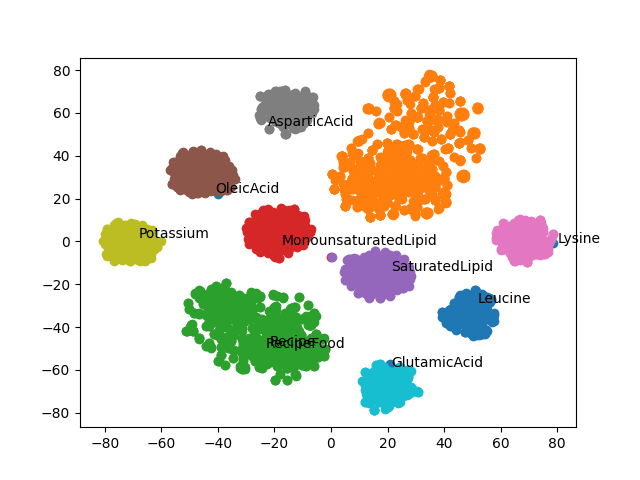

In [74]:
X_embedded = TSNE(n_components=2, n_jobs = -1, early_exaggeration= 20).fit_transform(combined_data)

_plot(X_embedded, tsne_X_label, tsne_classes_clean, tsne_class_label)

## class-entity experiment

In [70]:
tsne_classes = positive_samples_df["class"].unique().tolist() 
tsne_classes_clean = [clean(l) for l in tsne_classes]
tsne_classes_embedded = [classes_e[classes.index(cls)] for cls in tsne_classes]

tsne_entity = positive_samples_df["individual"].sample(1000, replace=False).tolist()
tsne_entity_embedded = [individuals_e[individuals.index(ind)] for ind in tsne_entity]

combined_data = tsne_classes_embedded + tsne_entity_embedded
combined_color = ['red'] * len(tsne_classes_embedded) + ['grey'] * len(tsne_entity_embedded)
combined_data = np.array(combined_data)


In [66]:
X_embedded = TSNE(n_components=2, n_jobs = -1, early_exaggeration= 20).fit_transform(combined_data)


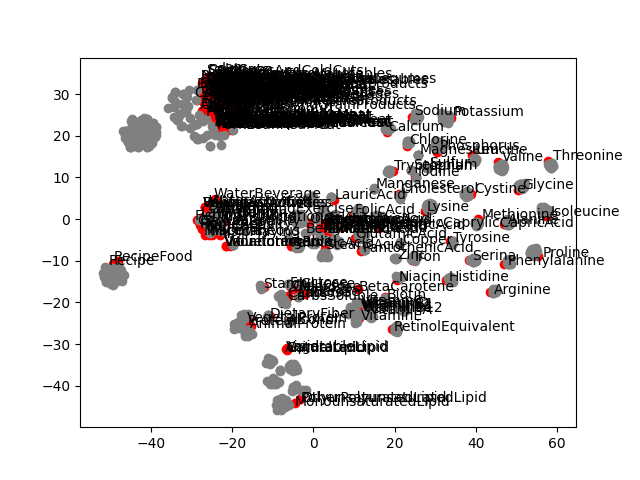

In [71]:
plt.clf()
for i, (x, y), color in (zip(range(len(combined_color)), X_embedded, combined_color)):
    plt.plot(x, y, 'o', c = color)
    if color == 'red':
            plt.text(x * (1.02), y * (1.02) , tsne_classes_clean[i], fontsize=10)
plt.show()